<a href="https://colab.research.google.com/github/bohessburg/SpiderLeagueClassifier/blob/main/SpiderLeagueClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# To download the dataset, install the kaggle CLI (`pip install kaggle`),
# configure your API credentials (~/.kaggle/kaggle.json), then run:
# kaggle datasets download -d gpiosenka/yikes-spiders-15-species -p data --unzip

In [1]:
!pip -q install kaggle timm seaborn scikit-learn huggingface_hub

In [2]:
import json, os

kaggle_creds = {
    "username": "YOUR_KAGGLE_USERNAME",
    "key": "YOUR_KAGGLE_API_KEY"
}

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_creds, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)

In [3]:
!kaggle datasets download -d gpiosenka/yikes-spiders-15-species -p data --unzip

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/yikes-spiders-15-species
License(s): unknown
  0% 0.00/57.5M [00:00<?, ?B/s]
100% 57.5M/57.5M [00:00<00:00, 1.65GB/s]


In [4]:
import argparse
import os
import kaggle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from huggingface_hub import hf_hub_download, HfApi

In [5]:
#--Constants--

DATA_DIR = 'data'

MODEL_PATH = 'spider_classifier.pth'
HF_REPO_ID = "YOUR_HF_REPO/SpiderLeague"
HF_MODEL_FILENAME = "spider_classifier.pth" #For uploading your own trained model weights to Hugging Face

IMAGE_SIZE = 224
NUM_CLASSES = 15

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [6]:
CLASS_NAMES = [
    'Black Widow', 'Blue Tarantula', 'Bold Jumper', 'Brown Grass Spider',
    'Brown Recluse Spider', 'Deinopis Spider', 'Golden Orb Weaver',
    'Hobo Spider', 'Huntsman Spider', 'Ladybird Mimic Spider',
    'Peacock Spider', 'Red Knee Tarantula', 'Spiny Backed Orb Weaver',
    'White Knee Spider', 'Yellow Garden Spider',
]

In [7]:
#Use random number seed to ensure consistent results for testing/validating/debugging etc
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
#Randomly flip, rotate, zoom, and recolor images to expand effective training dataset and ensure emphasis of unique features rather than
#overall pose of the spiders.
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.08, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [9]:
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [10]:
class SpiderClassificationHead(nn.Module):
    """
    Multi-layer classification head for spider species classification.

    Architecture:
      Linear(768 -> 512) -> BatchNorm -> ReLU -> Dropout(0.4)
      Linear(512 -> 256) -> BatchNorm -> ReLU -> Dropout(0.3)
      Linear(256 -> num_classes)

    Why this design:
    - Two hidden layers let the network learn non-linear feature combinations
      needed to distinguish similar looking species (e.g. Brown Recluse vs Hobo Spider)
    - Decreasing width (768 -> 512 -> 256) creates an information bottleneck that
      forces the network to distill the most discriminative features.
    - Dropout is aggressive (0.4) because the dataset is small (~2K training images)
    """
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.head(x)


#Full model consists of the head defined above and the pre-trained ConvNeXt-Tiny
class SpiderClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # ConvNeXt-Tiny: a modernized ResNet that uses ideas from Vision Transformers
        self.backbone = timm.create_model('convnext_tiny', pretrained=True, num_classes=0)

        #instance of our head class defined above
        self.classifier = SpiderClassificationHead(
            in_features=self.backbone.num_features,  # 768 for convnext_tiny
            num_classes=num_classes,
        )

    def forward(self, x):
        features = self.backbone(x)       # (batch, 768)
        return self.classifier(features)

In [11]:
"""This cell contains a number of helper functions for validating the model and visualizing results.
It also contains functions to upload and download trained models through Hugging Face"""


def evaluate_model(model, dataloader, class_names, device):
    #Compute overall accuracy, per-class accuracy, and confusion matrix.
    #Confusion matrix assesses which classes are mistaken for each other

    #Switch model to eval mode. This disables dropout so that all neurons stay active
    model.eval()

    #running list of all predictions and the corresponding correct labels
    all_preds, all_labels = [], []

    #During evaluation there is no back-propogation, so torch.no_grad disables
    #gradient computation and allows us to only do forward pass.
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images) #tensor of shape(batch_size,num_classes) containing class preedictions for each batch element
            _, predicted = torch.max(outputs, 1) #Max along class dimension of output tensor to determine if best prediction is accurate
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    #overall accuracy is based on the model's strongest prediction for each image. For example, if the output is
    #40% Brown recluse and 60% Hobo spider, and the true label is Hobo Spider, this will count as correct towards the total accuracy.
    overall_acc = (all_preds == all_labels).mean()

    #compute confusion matrix to see how similar different labels seem to the Neural network
    report = classification_report(all_labels, all_preds, target_names=class_names)
    cm = confusion_matrix(all_labels, all_preds)

    return overall_acc, report, cm


def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Spider Species Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)


def predict(model, image_tensor, device):
    #Predict the class of a single image tensor
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names):
    #Displays image next to a bar plot representing predictions
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)
    plt.tight_layout()
    plt.show()

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    #wraps each epoch of training into a single function call to keep __main__ code readable

    #Switch to training mode, enabling gradient computation and backpropogation
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        #---------------
        """This block of code is a very common pytorch pattern used to train almost any model.
        Training per image consists of resetting the gradient computations, doing a forward pass on
        the image, computing loss, computing the gradient with loss.backward(), then updating weights and
        biases with optimizer.step()"""
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #---------------

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def validate(model, dataloader, criterion, device):
    #Evaluates accuracy using validation dataset. Single Epoch.
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0


    with torch.no_grad(): #disables gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

def download_model():
    print(f"Downloading pretrained model from {HF_REPO_ID}...")
    path = hf_hub_download(repo_id=HF_REPO_ID, filename=HF_MODEL_FILENAME)
    return path


def upload_model():
    if not os.path.exists(MODEL_PATH):
        print("No model file found. Train the model first.")
        return
    print(f"Uploading model to {HF_REPO_ID}...")
    api = HfApi()
    api.create_repo(repo_id=HF_REPO_ID, exist_ok=True)
    api.upload_file(
        path_or_fileobj=MODEL_PATH,
        path_in_repo=HF_MODEL_FILENAME,
        repo_id=HF_REPO_ID,
    )
    print(f"Model uploaded to https://huggingface.co/{HF_REPO_ID}")

In [12]:
if __name__ == "__main__":
    #If running on a colab notebook, these arguments can be disregarded.
    parser = argparse.ArgumentParser(description="SpiderLeague: Spider Species Classifier")
    parser.add_argument("--infer", type=str, metavar="IMAGE_PATH",
                        help="Skip training. Download pretrained model and classify the given image.")
    parser.add_argument("--upload", action="store_true",
                        help="Upload best_spider_model.pth to Hugging Face Hub after training.")
    args, unknown = parser.parse_known_args() # Modified line

    # ── Inference-only mode ──────────────────────────────────────────────
    if args.infer:
        model = SpiderClassifier(num_classes=NUM_CLASSES).to(device)

        # Use local model if available, otherwise download from HF Hub
        if os.path.exists(MODEL_PATH):
            print(f"Loading local model from {MODEL_PATH}")
            weights_path = MODEL_PATH
        else:
            weights_path = download_model()

        model.load_state_dict(torch.load(weights_path, map_location=device))

        original_image, image_tensor = preprocess_image(args.infer, eval_transform)
        probabilities = predict(model, image_tensor, device)
        visualize_predictions(original_image, probabilities, CLASS_NAMES)
        exit()

    # ── Training mode ────────────────────────────────────────────────────

    # Load datasets
    train_ds = ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
    valid_ds = ImageFolder(os.path.join(DATA_DIR, 'valid'), transform=eval_transform)
    test_ds = ImageFolder(os.path.join(DATA_DIR, 'test'), transform=eval_transform)

    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)
    test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

    print(f"Classes ({len(train_ds.classes)}): {train_ds.classes})")
    print(f"Training samples: {len(train_ds)}")

    model = SpiderClassifier(num_classes=NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0.0 #track accuracy to determine which model to save. The best is not always the newest

    # ── Phase 1: Train head only (backbone frozen) ───────────────────
    # The backbone has good ImageNet features. The head is randomly initialized.
    # If we train everything together, the random gradients from the head would
    # destroy the pretrained features. So we freeze the backbone first.

    print("\n=== Phase 1: Training classification head (backbone frozen) ===")

    for param in model.backbone.parameters():
        param.requires_grad = False

    optimizer_p1 = optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=1e-4)
    num_epochs_p1 = 10

    for epoch in range(num_epochs_p1):
        if device.type == "cuda":
            torch.cuda.empty_cache()

        train_loss, train_acc = train_one_epoch(model, train_dl, criterion, optimizer_p1, device)
        val_loss, val_acc = validate(model, valid_dl, criterion, device)

        print(f"  Epoch {epoch+1}/{num_epochs_p1} — "
              f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
              f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"    -> Saved best model (val_acc={val_acc:.4f})")

    # ── Phase 2: Fine-tune everything with discriminative learning rates ──
    # Now the head is trained, so gradients flowing into the backbone will be meaningful.
    # We use a much smaller LR for the backbone (pretrained features need gentle updates)
    # and a moderately smaller LR for the head (already partially converged).

    print("\n=== Phase 2: Fine-tuning full model (backbone unfrozen) ===")

    for param in model.backbone.parameters():
        param.requires_grad = True

    optimizer_p2 = optim.AdamW([
        {'params': model.backbone.parameters(), 'lr': 1e-5},    # backbone: very small LR
        {'params': model.classifier.parameters(), 'lr': 1e-4},  # head: 10x backbone LR
    ], weight_decay=1e-4)

    num_epochs_p2 = 20
    #decays learning rate over time, important for fine tuning to avoid over-adjusting during gradient descent
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_p2, T_max=num_epochs_p2, eta_min=1e-7)

    for epoch in range(num_epochs_p2):
        if device.type == "cuda":
            torch.cuda.empty_cache()

        train_loss, train_acc = train_one_epoch(model, train_dl, criterion, optimizer_p2, device)
        val_loss, val_acc = validate(model, valid_dl, criterion, device)
        scheduler.step()

        print(f"  Epoch {epoch+1}/{num_epochs_p2} — "
              f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
              f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"    -> Saved best model (val_acc={val_acc:.4f})")

    upload_model()

Classes (15): ['Black Widow', 'Blue Tarantula', 'Bold Jumper', 'Brown Grass Spider', 'Brown Recluse Spider', 'Deinopis Spider', 'Golden Orb Weaver', 'Hobo Spider', 'Huntsman Spider', 'Ladybird Mimic Spider', 'Peacock Spider', 'Red Knee Tarantula', 'Spiny-backed Orb-weaver', 'White Kneed Tarantula', 'Yellow Garden Spider'])
Training samples: 2185


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


=== Phase 1: Training classification head (backbone frozen) ===
  Epoch 1/10 — Train loss: 1.1739, acc: 0.6430 | Val loss: 0.3576, acc: 0.9333
    -> Saved best model (val_acc=0.9333)
  Epoch 2/10 — Train loss: 0.6238, acc: 0.7890 | Val loss: 0.2540, acc: 0.9200
  Epoch 3/10 — Train loss: 0.5439, acc: 0.8197 | Val loss: 0.1848, acc: 0.9600
    -> Saved best model (val_acc=0.9600)
  Epoch 4/10 — Train loss: 0.4880, acc: 0.8243 | Val loss: 0.2060, acc: 0.9067
  Epoch 5/10 — Train loss: 0.4704, acc: 0.8439 | Val loss: 0.1260, acc: 0.9600
  Epoch 6/10 — Train loss: 0.4338, acc: 0.8563 | Val loss: 0.1052, acc: 0.9733
    -> Saved best model (val_acc=0.9733)
  Epoch 7/10 — Train loss: 0.4111, acc: 0.8645 | Val loss: 0.1081, acc: 0.9600
  Epoch 8/10 — Train loss: 0.3908, acc: 0.8764 | Val loss: 0.1048, acc: 0.9600
  Epoch 9/10 — Train loss: 0.3845, acc: 0.8705 | Val loss: 0.0930, acc: 0.9867
    -> Saved best model (val_acc=0.9867)
  Epoch 10/10 — Train loss: 0.3643, acc: 0.8673 | Val loss: 

HfHubHTTPError: Client error '401 Unauthorized' for url 'https://huggingface.co/api/repos/create' (Request ID: Root=1-698ba58f-6d9e666f45fef691420d1777;f07162b1-2037-49ce-bf2d-b488e644bc80)
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/401

Invalid username or password.


=== Test Set Evaluation ===
Overall test accuracy: 1.0000
                         precision    recall  f1-score   support

            Black Widow       1.00      1.00      1.00         5
         Blue Tarantula       1.00      1.00      1.00         5
            Bold Jumper       1.00      1.00      1.00         5
     Brown Grass Spider       1.00      1.00      1.00         5
   Brown Recluse Spider       1.00      1.00      1.00         5
        Deinopis Spider       1.00      1.00      1.00         5
      Golden Orb Weaver       1.00      1.00      1.00         5
            Hobo Spider       1.00      1.00      1.00         5
        Huntsman Spider       1.00      1.00      1.00         5
  Ladybird Mimic Spider       1.00      1.00      1.00         5
         Peacock Spider       1.00      1.00      1.00         5
     Red Knee Tarantula       1.00      1.00      1.00         5
Spiny-backed Orb-weaver       1.00      1.00      1.00         5
  White Kneed Tarantula       

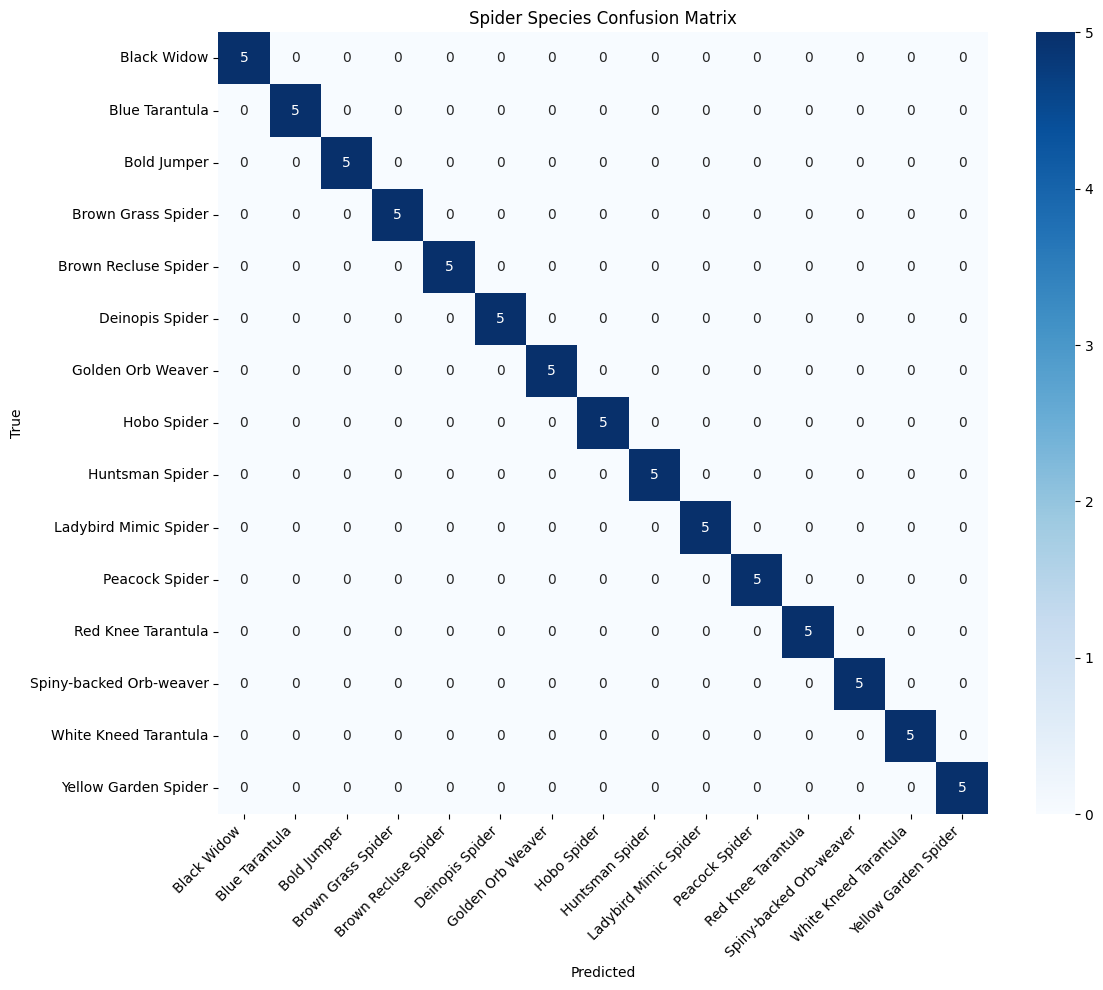

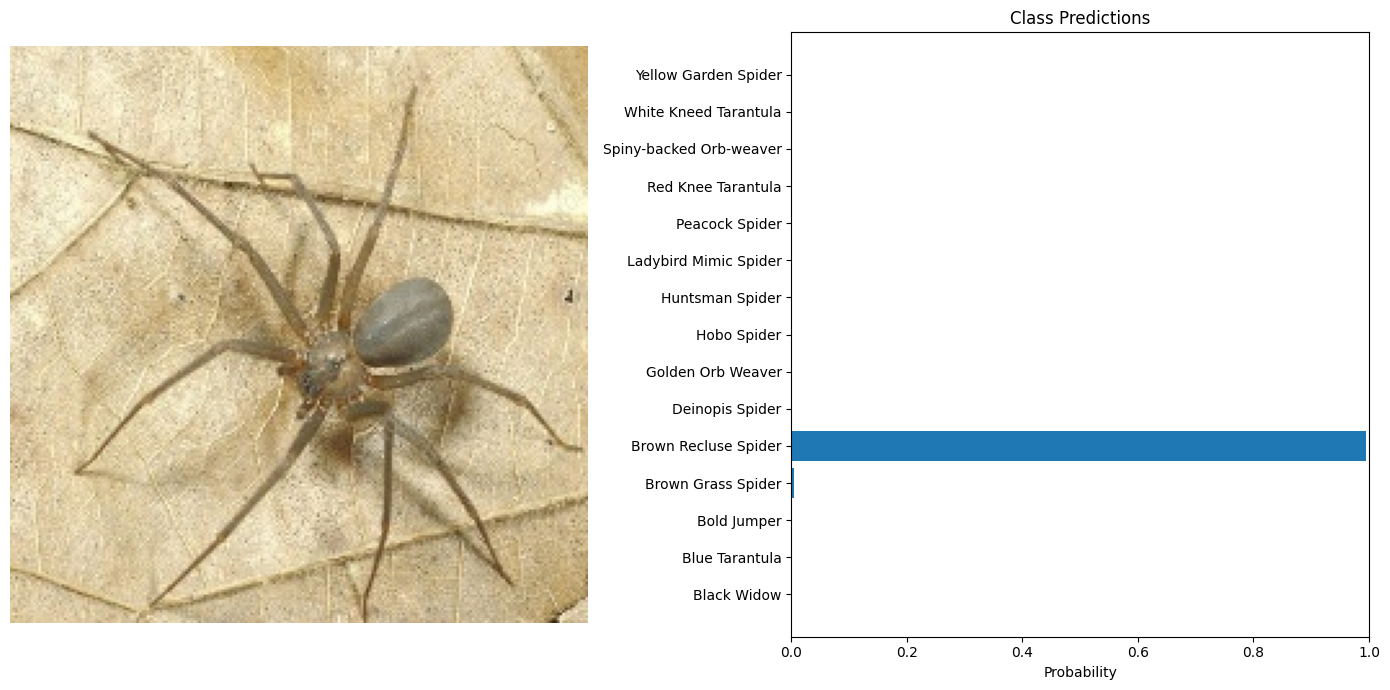

In [16]:
#Final evaluation on test set
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

print("\n=== Test Set Evaluation ===")
class_names = train_ds.classes
overall_acc, report, cm = evaluate_model(model, test_dl, class_names, device)
print(f"Overall test accuracy: {overall_acc:.4f}")
print(report)
plot_confusion_matrix(cm, class_names)

    #Upload to Hugging Face Hub if requested
if args.upload:
    upload_model()

    #Single image inference example
test_image_path = os.path.join(DATA_DIR, "test", "Brown Recluse Spider", "3.jpg")
original_image, image_tensor = preprocess_image(test_image_path, eval_transform)
probabilities = predict(model, image_tensor, device)
visualize_predictions(original_image, probabilities, class_names)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')